**COMBINING ALL MODELS**

**WRITER IDENTIFIER**

In [43]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from skimage.feature import corner_harris, corner_peaks
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the saved model once
model_path = 'signature_recognition_part1.h5'
model_writer = load_model(model_path)

# Label encoder for decoding the prediction
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_classes.npy', allow_pickle=True)  # Load previously saved classes

def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    
    resized_image = cv2.resize(image, img_size)
    normalized_image = resized_image / 255.0
    normalized_image = np.expand_dims(normalized_image, axis=-1)  # Add channel dimension
    normalized_image = np.expand_dims(normalized_image, axis=0)   # Add batch dimension
    return normalized_image

def predict_writer(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    
    # Predict writer
    predictions = model_writer.predict(processed_image,verbose=0)
    writer_index = np.argmax(predictions)
    writer_number = label_encoder.inverse_transform([writer_index])[0]
    
    return writer_number

**FORGERY DETECTION**

In [45]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from skimage.feature import corner_harris, corner_peaks
from sklearn.svm import SVC
import joblib
import os
import cv2
import numpy as np
img_size = (128, 128)

In [54]:
# Define the function for image classification
def forgery_detection(image_path,writerid):
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or unable to open.")
    
    # Resize and preprocess the image
    img = cv2.resize(img, img_size)
    
    # Extract features
    lbp = local_binary_pattern(img, P=1, R=4, method="uniform").flatten()
    glcm = graycomatrix(img, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, prop='contrast')[0, 0]
    mean = img.mean()
    std = img.std()
    corners = corner_harris(img)
    corner_count = np.sum(corners > 0.01 * corners.max()) 
    
    #features = np.hstack([lbp.mean(), lbp.std(), contrast, mean, std,corner_count]).reshape(1, -1)
    features = np.hstack([lbp.mean()]).reshape(1, -1)

    # Load scaler back 
    model_dir = "svm_models"
    model_path = os.path.join(model_dir, f"signature_scaler_writer_{writerid}.joblib")
    scaler = joblib.load(model_path)
    # Scale features
    features = scaler.transform(features)

    
    # Load models back 
    model_dir = "svm_models"
    model_path = os.path.join(model_dir, f"signature_classifier_writer_{writerid}.joblib")
    model = joblib.load(model_path)
    # Predict using the trained model
    prediction = model.predict(features)
    
    return "Genuine" if prediction[0] == 0 else "Forged"

**COMPLETE MODEL EVALUATION**

In [55]:
correct_classify=0
total = 0 
TP=0
TN=0
FP=0
FN=0
for i in range(1,56):
    print(i,end=" ")
    for j in range(1,25):
        image_path = 'signatures/full_forg/forgeries_'+ str(i)+'_'+str(j)+'.png'
        writerid = predict_writer(image_path)
        result = forgery_detection(image_path,writerid)
        if result == 'Forged':
            TN+=1
            correct_classify+=1
        if result == 'Genuine':
            FP+=1
        total+=1
    for j in range(1,25):
        image_path = 'signatures/full_org/original_'+ str(i)+'_'+str(j)+'.png'
        writerid = predict_writer(image_path)
        result = forgery_detection(image_path,writerid)
        if result == 'Forged':
            FN+=1
        if result == 'Genuine':
            TP+=1
            correct_classify+=1
        total+=1
print("\nEvalution of combined model completed!")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
Evalution of combined model completed!


In [56]:
correct_classify

2383

In [57]:
acc_score=round(correct_classify/total,4)
print('Overall accuracy of model is ',acc_score*100,'%.',sep='')

Overall accuracy of model is 90.27%.


In [58]:
cnf = [[TP,FN],[FP,TN]]
cnf

[[1267, 53], [204, 1116]]

Text(0.5, 1.0, 'Confusion Matrix for Signature Forgery Detection')

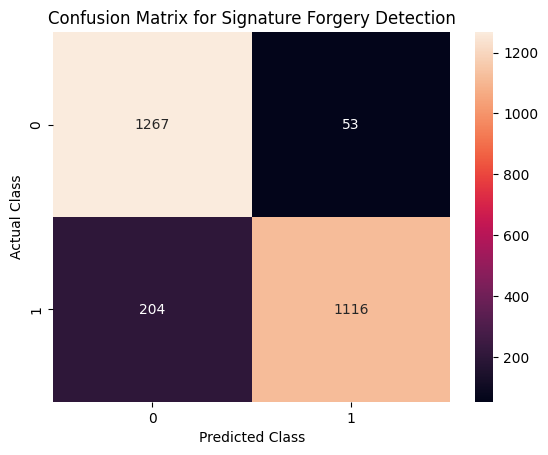

In [59]:
sns.heatmap(cnf,annot=True,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix for Signature Forgery Detection')

__*EXAMPLE WITH A SIGNATURE IMAGE*__

In [60]:
path = 'signatures/full_forg/forgeries_1_2.png'
writer = predict_writer(path)
prediction = forgery_detection(path, writer)

print(f"Signature belong to Writer {writer} and it is a {prediction} signature.")

Signature belong to Writer 1 and it is a Forged signature.
